<left>FINM 36702 - Portfolio Credit Risk: Modeling and Estimation</left>
<left>Spring 2023</left>
<br>
<h1><center> Assignment 2 </center></h1>
<center>Due - 18:00 [CST] April 6th, 2023</center>
<br>
<h3>Ki Hyun</h3>
<h3>Student ID: 12125881</h3>

### Imports

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import norm
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt

### Helper Functions

In [3]:
def sim_MVN(mu, sigma, strands, seed):
    np.random.seed(seed) # setting the seed
    return np.random.multivariate_normal(mu, sigma, strands) # returning the simulated numpy array

In [4]:
def sim_Default(PDs, sim_result):
    threshold = np.tile(norm.ppf(PDs), (sim_result.shape[0], 1)) # matching the Gaussian default threshold format
    relative_position = sim_result - threshold # getting the relevant position of the simulation in terms of threshold

    return np.where(relative_position < 0, 1, 0) # returning numpy array with "1" as default and "0" otherwise

In [5]:
def Default_summary(sim_result):
    agg = sim_result.sum(axis = 1)
    df = pd.DataFrame({'Number of Firms': [agg.mean(), agg.std()]},
                      index = ['Mean', 'Std. Dev.'])

    return df

In [6]:
def Sigma_generator(rho, nrow):
    sigma = []
    for i in range(nrow):
        row = []
        for j in range(nrow):
            if i == j:
                row.append(1)
            else:
                row.append(rho)
        sigma.append(row)

    return np.array(sigma)

In [7]:
def MC_Default_std(rho, PDs, mu, strands, seed):
    Sigma = Sigma_generator(rho, len(PDs))
    sim_result = sim_Default(PDs, sim_MVN(mu, Sigma, strands, seed))
    return sim_result.sum(axis = 1).std()

### Constants

In [8]:
seed = 5881

# Question 1.

#### Given Correlation Matrix

In [9]:
mu_1 = np.repeat(0, 5)

In [10]:
Sigma_1 = np.array([[1, 0.05, 0.1, 0.15, 0.2],
                    [0.05, 1, 0.25, 0.3, 0.35],
                    [0.1, 0.25, 1, 0.4, 0.45],
                    [0.15, 0.3, 0.4, 1, 0.5],
                    [0.2, 0.35, 0.45, 0.5, 1]])

In [11]:
PDs_1 = np.array([0.5, 0.4, 0.3, 0.2, 0.1])

In [12]:
n_strands_1 = 10000

In [13]:
sim_results_1 = sim_MVN(mu_1, Sigma_1, n_strands_1, seed)

In [14]:
x = sim_Default(PDs_1, sim_results_1)

In [15]:
Default_summary(x)

,Number of Firms
Mean,1.501600
Std. Dev.,1.201914


#### Modified Correlation Matrix

In [16]:
Sigma_2 = np.array([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]])

In [17]:
sim_results_2 = sim_MVN(mu_1, Sigma_2, n_strands_1, seed)

In [18]:
x = sim_Default(PDs_1, sim_results_2)

In [19]:
Default_summary(x)

,Number of Firms
Mean,1.494200
Std. Dev.,0.976712


# Question 2.

In [20]:
rhos = np.arange(start = 0, stop = 0.95, step = 0.01)

In [21]:
n_strands_2 = 1000

In [22]:
partial_func = partial(MC_Default_std, PDs = PDs_1, mu = mu_1, strands = n_strands_2, seed = seed)

In [23]:
y = np.vectorize(partial_func)(rhos)

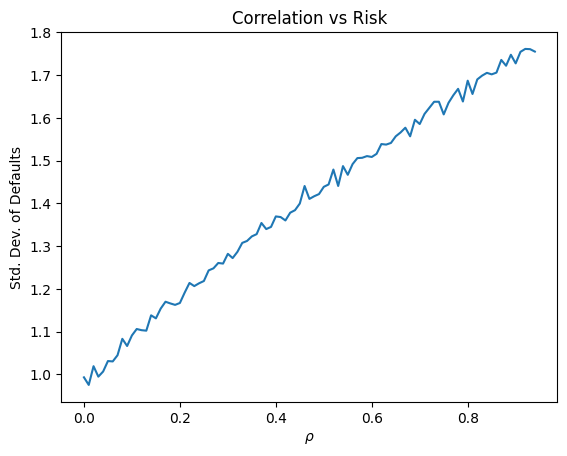

In [24]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(rhos, y)

# Add labels and title
ax.set_xlabel(r'$\rho$')
ax.set_ylabel('Std. Dev. of Defaults')
ax.set_title('Correlation vs Risk')

# Show the plot
plt.show()
None

# Question 3.

#### PDJ of Firm 4 and Firm 5

In [25]:
PDs_3 = [0.1, 0.2, 0.3, 0.4, 0.5]

In [26]:
Sigma_3 = np.array([[1, 0.15, 0.2, 0.25, 0.3],
                    [0.15, 1, 0.25, 0.3, 0.35],
                    [0.2, 0.25, 1, 0.35, 0.4],
                    [0.25, 0.3, 0.35, 1, 0.45],
                    [0.3, 0.35, 0.4, 0.45, 1]])

In [27]:
multivariate_normal(mean = mu_1, cov = Sigma_3).cdf([np.inf, # Firm 1
                                                     np.inf, # Firm 2
                                                     np.inf, # Firm 3
                                                     norm.ppf(PDs_3)[3], # Firm 4
                                                     norm.ppf(PDs_3)[4]]) # Firm 5

0.27175852116748356

#### Conditional Default probability

In [28]:
joint_P = multivariate_normal(mean = mu_1, cov = Sigma_3).cdf([np.inf, # Firm 1
                                                               np.inf, # Firm 2
                                                               norm.ppf(PDs_3)[2], # Firm 3
                                                               norm.ppf(PDs_3)[3], # Firm 4
                                                               norm.ppf(PDs_3)[4]]) # Firm 5

In [29]:
conditional_case = multivariate_normal(mean = mu_1, cov = Sigma_3).cdf([np.inf, # Firm 1
                                                                        np.inf, # Firm 2
                                                                        norm.ppf(PDs_3)[2], # Firm 3
                                                                        np.inf, # Firm 4
                                                                        np.inf]) # Firm 5

In [30]:
joint_P/conditional_case

0.44324468696421687

#### Expected Loss Rate

In [31]:
n_strands_3 = 1000000

In [32]:
Exposures = np.array([700, 600, 500, 400, 300, 200, 100])

In [33]:
ELGDs = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

In [47]:
Firms = np.array([1, 2, 3, 4, 5, 4, 5])

In [51]:
Expected_Loss = []
for firm in range(1, 6):
    Expected_Loss.append((Exposures * ELGDs)[Firms == firm].sum())

In [53]:
Expected_Loss = np.array(Expected_Loss)

In [38]:
sim_results_3 = sim_MVN(mu_1, Sigma_3, n_strands_3, seed)

In [39]:
x = sim_Default(PDs_3, sim_results_3)

In [59]:
(x.mean(axis = 0) * Expected_Loss).sum() / 2800

0.10650584285714286

#### Default Correlation

In [55]:
PDJ = multivariate_normal(mean = mu_1, cov = Sigma_3).cdf([np.inf, # Firm 1
                                                           np.inf, # Firm 2
                                                           norm.ppf(PDs_3)[2], # Firm 3
                                                           norm.ppf(PDs_3)[3], # Firm 4
                                                           np.inf]) # Firm 5

In [56]:
(PDJ - PDs_3[2] * PDs_3[3]) / ((PDs_3[2] * (1 - PDs_3[2]) * PDs_3[3] * (1 - PDs_3[3])) ** 0.5)

0.2177297759360109

# Question 4.